# Importar librerias

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Funciones auxiliares

In [20]:
# Function to calculate the correlation matrix and plot a heatmap
def matriz_correlacion(dataset, target):
    corr_matrix = dataset.corr()
    corr_matrix[target].sort_values(ascending=False)
    cm_red_blue = mpl.colormaps['RdBu']
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cm_red_blue, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Heatmap with Numerical Values and Colors')
    plt.show()

In [4]:
# Calcular el VIF para cada característica
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [51]:
# Iteratively remove features with high VIF
def remove_high_vif_features(df, threshold=10):
    while True:
        vif_data = calculate_vif(df)
        max_vif = vif_data['VIF'].max()
        if max_vif > threshold:
            feature_to_remove = vif_data.loc[vif_data['VIF'] == max_vif, 'feature'].values[0]
            df = df.drop(columns=[feature_to_remove])
        else:
            break
    return df, vif_data

In [5]:
# Función para entrenar y evaluar un modelo
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Preprocesamiento

In [6]:
average_cluster_0=pd.read_csv("../data/interim/average_series_cluster_0.csv",parse_dates=["Date/Time"])

In [7]:
average_cluster_0.shape

(8783, 7)

In [8]:
average_cluster_0.head()

,Date/Time,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly)
0,2004-01-01 01:00:00,47.210969,5.789775,3.010854,4.637630,6.918895,10.669373
1,2004-01-01 02:00:00,47.047291,5.946731,3.048947,4.450657,6.588343,10.525933
2,2004-01-01 03:00:00,45.619393,5.862989,2.883068,5.406697,5.084587,10.308935
3,2004-01-01 04:00:00,45.697195,6.186896,2.968095,4.801340,5.084587,10.297614
4,2004-01-01 05:00:00,47.030928,5.832209,2.942949,5.603789,5.182567,10.482863


In [9]:
average_cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date/Time                                   8783 non-null   datetime64[ns]
 1   Electricity:Facility [kW](Hourly)           8395 non-null   float64       
 2   Fans:Electricity [kW](Hourly)               8395 non-null   float64       
 3   Cooling:Electricity [kW](Hourly)            8395 non-null   float64       
 4   Heating:Electricity [kW](Hourly)            8395 non-null   float64       
 5   InteriorLights:Electricity [kW](Hourly)     8395 non-null   float64       
 6   InteriorEquipment:Electricity [kW](Hourly)  8395 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 480.4 KB


In [10]:
average_cluster_0.isna().sum()

Date/Time                                       0
Electricity:Facility [kW](Hourly)             388
Fans:Electricity [kW](Hourly)                 388
Cooling:Electricity [kW](Hourly)              388
Heating:Electricity [kW](Hourly)              388
InteriorLights:Electricity [kW](Hourly)       388
InteriorEquipment:Electricity [kW](Hourly)    388
dtype: int64

In [11]:
# Imputar o eliminar valores faltantes si existen
average_cluster_0.fillna(method='ffill', inplace=True)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_12188\1271873523.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  average_cluster_0.fillna(method='ffill', inplace=True)


In [12]:
average_cluster_0.isna().sum()

Date/Time                                     0
Electricity:Facility [kW](Hourly)             0
Fans:Electricity [kW](Hourly)                 0
Cooling:Electricity [kW](Hourly)              0
Heating:Electricity [kW](Hourly)              0
InteriorLights:Electricity [kW](Hourly)       0
InteriorEquipment:Electricity [kW](Hourly)    0
dtype: int64

In [13]:
# Establecer la columna de fecha como índice
average_cluster_0.set_index('Date/Time', inplace=True)

In [14]:
# Extraer características temporales
average_cluster_0['hour'] = average_cluster_0.index.hour
average_cluster_0['day_of_week'] = average_cluster_0.index.dayofweek
average_cluster_0['month'] = average_cluster_0.index.month

In [15]:
# Feature engineering: Adding lag features and rolling statistics
for lag in range(1, 25):
    average_cluster_0[f'lag_{lag}'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].shift(lag)

average_cluster_0['rolling_mean_24'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].rolling(window=24).mean()
average_cluster_0['rolling_std_24'] = average_cluster_0['Electricity:Facility [kW](Hourly)'].rolling(window=24).std()

# Drop rows with NaN values resulting from lag features
average_cluster_0.dropna(inplace=True)

In [16]:
average_cluster_0.head()

,Electricity:Facility [kW](Hourly),Fans:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),Heating:Electricity [kW](Hourly),InteriorLights:Electricity [kW](Hourly),InteriorEquipment:Electricity [kW](Hourly),hour,day_of_week,month,lag_1,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_std_24
Date/Time,,,,,,,,,,,,,,,,,,,,,
2004-01-02 01:00:00,47.018858,5.923903,3.534635,3.316889,6.293503,11.184991,1,4,1,64.440189,...,65.372000,64.095870,49.861330,47.030928,45.697195,45.619393,47.047291,47.210969,63.539435,10.922902
2004-01-02 02:00:00,43.385898,5.234743,3.315371,2.708412,5.374666,10.944374,2,4,1,47.018858,...,74.586505,65.372000,64.095870,49.861330,47.030928,45.697195,45.619393,47.047291,63.386877,11.185668
2004-01-02 03:00:00,44.135864,5.594996,3.560628,3.404574,4.720944,10.824553,3,4,1,43.385898,...,65.194483,74.586505,65.372000,64.095870,49.861330,47.030928,45.697195,45.619393,63.325063,11.291719
2004-01-02 04:00:00,43.525580,5.442821,4.089989,2.711906,4.720944,10.813232,4,4,1,44.135864,...,63.708467,65.194483,74.586505,65.372000,64.095870,49.861330,47.030928,45.697195,63.234579,11.446755
2004-01-02 05:00:00,48.451056,6.292467,4.586548,3.251925,5.453145,11.687134,5,4,1,43.525580,...,65.271422,63.708467,65.194483,74.586505,65.372000,64.095870,49.861330,47.030928,63.293751,11.362713


In [17]:
average_cluster_0.columns

Index(['Electricity:Facility [kW](Hourly)', 'Fans:Electricity [kW](Hourly)',
       'Cooling:Electricity [kW](Hourly)', 'Heating:Electricity [kW](Hourly)',
       'InteriorLights:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'hour', 'day_of_week',
       'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
       'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14',
       'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21',
       'lag_22', 'lag_23', 'lag_24', 'rolling_mean_24', 'rolling_std_24'],
      dtype='object')

In [18]:
target='Electricity:Facility [kW](Hourly)'

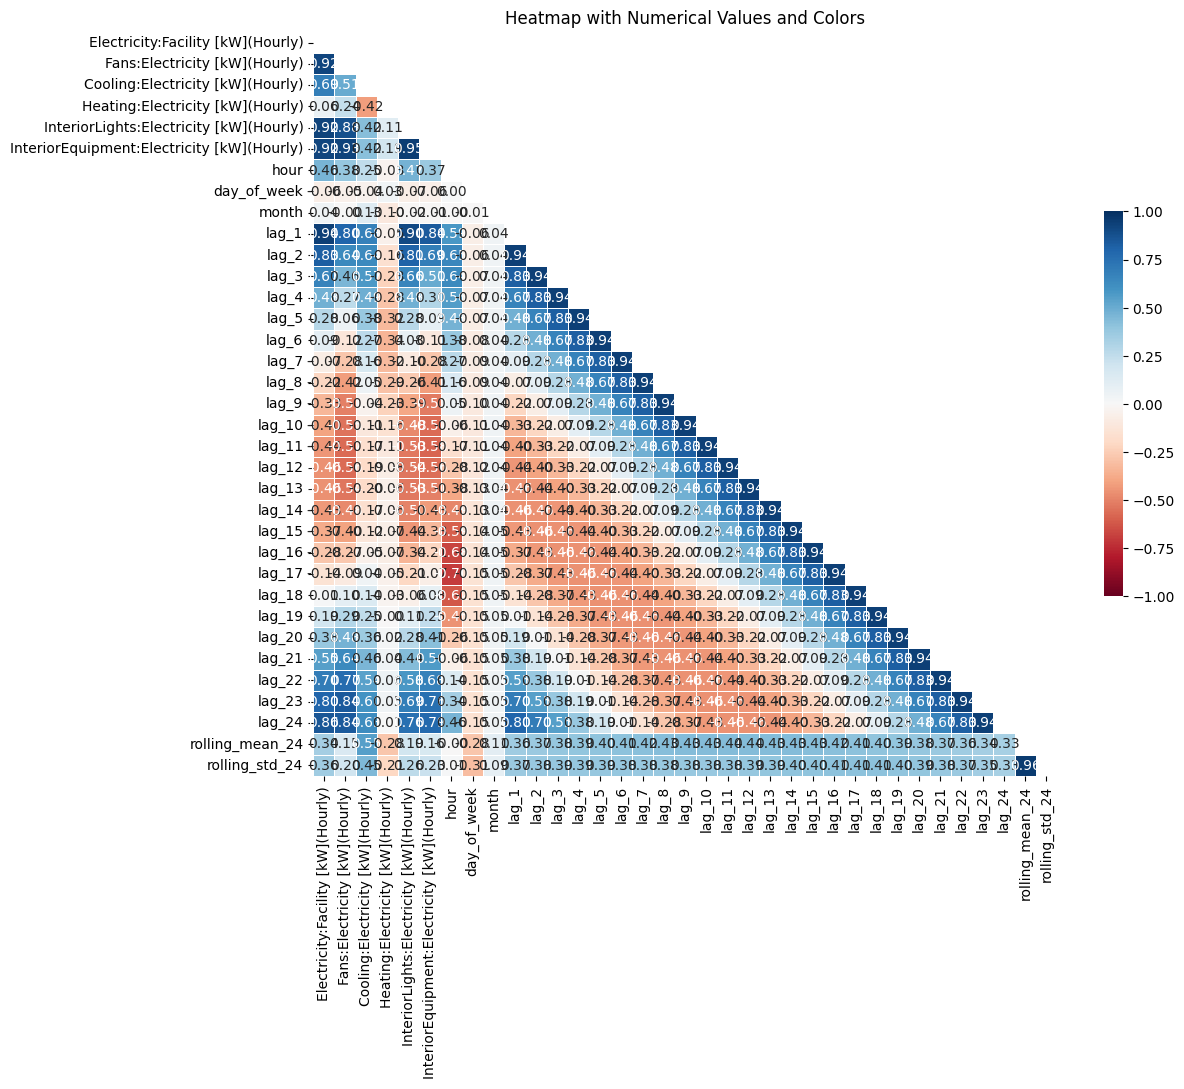

In [21]:
matriz_correlacion(average_cluster_0, target)

La correlación mide la relación entre dos variables. Puede ir de -1 a 1.

* 1 significa una relación positiva perfecta.
* -1 significa una relación negativa perfecta.
* 0 significa que no hay relación.

In [22]:
# Calcular la correlación de cada característica con la variable objetivo
correlation_matrix = average_cluster_0.corr()
target_correlation = correlation_matrix['Electricity:Facility [kW](Hourly)'].sort_values(ascending=False)

# Mostrar la correlación de cada característica con la variable objetivo
target_correlation


Electricity:Facility [kW](Hourly)             1.000000
lag_1                                         0.941189
InteriorLights:Electricity [kW](Hourly)       0.922777
Fans:Electricity [kW](Hourly)                 0.918616
InteriorEquipment:Electricity [kW](Hourly)    0.918195
lag_24                                        0.856917
lag_2                                         0.825479
lag_23                                        0.803397
lag_22                                        0.695954
Cooling:Electricity [kW](Hourly)              0.690208
lag_3                                         0.668002
lag_21                                        0.548497
lag_4                                         0.483667
hour                                          0.462434
lag_20                                        0.375780
rolling_std_24                                0.355093
rolling_mean_24                               0.343513
lag_5                                         0.284135
lag_19    

Queremos saber qué variables están más relacionadas con la variable que queremos predecir (Electricity:Facility [kW](Hourly)).

Las variables con alta correlación pueden ser más útiles para nuestro modelo.

**Regla utilizada:**

* Seleccionamos variables con una correlación absoluta mayor o igual a 0.3. 
* Esto significa que estas variables tienen una relación suficientemente fuerte con nuestra variable objetivo.

In [23]:
# Mantener características con correlación absoluta mayor o igual a 0.3
selected_features = target_correlation[abs(target_correlation) >= 0.3].index.drop('Electricity:Facility [kW](Hourly)')
features_corr = average_cluster_0[selected_features]

In [24]:
features_corr.columns

Index(['lag_1', 'InteriorLights:Electricity [kW](Hourly)',
       'Fans:Electricity [kW](Hourly)',
       'InteriorEquipment:Electricity [kW](Hourly)', 'lag_24', 'lag_2',
       'lag_23', 'lag_22', 'Cooling:Electricity [kW](Hourly)', 'lag_3',
       'lag_21', 'lag_4', 'hour', 'lag_20', 'rolling_std_24',
       'rolling_mean_24', 'lag_9', 'lag_15', 'lag_10', 'lag_14', 'lag_11',
       'lag_13', 'lag_12'],
      dtype='object')

**Evaluación de la Multicolinealidad**

* La multicolinealidad ocurre cuando dos o más variables están altamente correlacionadas entre sí.

* Esto puede causar problemas en los modelos de regresión porque dificulta determinar el efecto individual de cada variable.
  
**¿Cómo evaluamos la multicolinealidad?**

* Usamos el Factor de Inflación de la Varianza (VIF). Un VIF alto (mayor a 10) indica multicolinealidad alta.

* Eliminamos las variables con VIF mayor a 10 para reducir la multicolinealidad y simplificar nuestro modelo.

In [52]:
# Paso 3: Evaluación de la Multicolinealidad
vif_before_corr = calculate_vif(features_corr)
vif_before_corr.sort_values(by="VIF",ascending=False)

,feature,VIF
15,rolling_mean_24,3783.748920
9,lag_3,421.043291
6,lag_23,406.355636
19,lag_14,399.770508
5,lag_2,396.837680
18,lag_10,390.660314
22,lag_12,388.002253
10,lag_21,384.909776
0,lag_1,381.725400
7,lag_22,378.386723


In [53]:
features_selected_corr, final_vif = remove_high_vif_features(features_corr)

In [58]:
final_vif

,feature,VIF
0,InteriorLights:Electricity [kW](Hourly),7.930236
1,Cooling:Electricity [kW](Hourly),3.857563
2,hour,5.977928
3,lag_20,7.764134
4,lag_9,5.456681


In [59]:
features_selected_corr

,InteriorLights:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),hour,lag_20,lag_9
Date/Time,,,,,
2004-01-02 01:00:00,6.293503,3.534635,1,47.030928,64.313768
2004-01-02 02:00:00,5.374666,3.315371,2,49.861330,70.155623
2004-01-02 03:00:00,4.720944,3.560628,3,64.095870,74.385803
2004-01-02 04:00:00,4.720944,4.089989,4,65.372000,79.973273
2004-01-02 05:00:00,5.453145,4.586548,5,74.586505,76.667082
...,...,...,...,...,...
2004-12-31 19:00:00,14.749611,6.007865,19,60.986608,64.575268
2004-12-31 20:00:00,16.006585,6.870403,20,60.986608,63.512774
2004-12-31 21:00:00,16.504439,7.675048,21,44.179487,66.110446


In [60]:
 taget_predict=average_cluster_0['Electricity:Facility [kW](Hourly)'].copy()

# Seleccion del modelo

In [61]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(features_selected_corr, taget_predict, test_size=0.2, random_state=42)

In [62]:
# Escalar las características
scaler_corr = StandardScaler()
X_train_scaled_corr = scaler_corr.fit_transform(X_train_corr)
X_test_scaled_corr = scaler_corr.transform(X_test_corr)

In [63]:
# Definir los modelos
models = {
    "Linear Regression": LinearRegression(),
    "Stepwise Linear Regression": Lasso(alpha=0.01),  # Utilizando Lasso como aproximación a la regresión paso a paso
    "Tree": DecisionTreeRegressor(),
    "SVM": SVR(kernel='rbf'),
    "Efficient Linear": LinearRegression(),  # Utilizando Linear Regression como proxy
    "Ensemble": VotingRegressor(estimators=[
        ('lr', LinearRegression()),
        ('dt', DecisionTreeRegressor()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Variables para almacenar resultados
results = {}

# Entrenar y evaluar cada modelo
for model_name, model in models.items():
    mse, r2 = train_evaluate_model(model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)
    results[model_name] = {'MSE': mse, 'R2 Score': r2}


In [64]:
# Convertir a DataFrame
df_results = pd.DataFrame(results)
df_results.head()

,Linear Regression,Stepwise Linear Regression,Tree,SVM,Efficient Linear,Ensemble,Random Forest
MSE,27.105669,27.113946,3.571477,11.106640,27.105669,4.990482,2.084018
R2 Score,0.966012,0.966001,0.995522,0.986073,0.966012,0.993742,0.997387


In [65]:
# Entrenar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo de Random Forest
mse_train_rf, r2_train_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_train_scaled_corr, y_train_corr, y_train_corr)
mse_test_rf, r2_test_rf = train_evaluate_model(rf_model, X_train_scaled_corr, X_test_scaled_corr, y_train_corr, y_test_corr)

# Resultados
rf_results = {
    "Random Forest": {
        'MSE Train': mse_train_rf, 
        'R2 Train': r2_train_rf,
        'MSE Test': mse_test_rf, 
        'R2 Test': r2_test_rf
    }
}

In [66]:
# Convertir a DataFrame y verificar overfitting
df_overfitting_results= pd.DataFrame(rf_results)
df_overfitting_results.head()

,Random Forest
MSE Test,2.084018
MSE Train,0.297231
R2 Test,0.997387
R2 Train,0.999626


# Mejorar hiperparametros

In [67]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # Validación cruzada de 3 pliegues
                           n_jobs=-1,  # Usar todos los núcleos disponibles
                           scoring='neg_mean_squared_error',
                           verbose=2)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train_scaled_corr, y_train_corr)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_

Fitting 3 folds for each of 216 candidates, totalling 648 fits


In [68]:
best_params

{'bootstrap': True,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [69]:
# Entrenar el modelo con los mejores hiperparámetros
optimized_rf_model = RandomForestRegressor(**best_params, random_state=42)
optimized_rf_model.fit(X_train_scaled_corr, y_train_corr)

# Evaluar el modelo optimizado
mse_train_opt = mean_squared_error(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))
r2_train_opt = r2_score(y_train_corr, optimized_rf_model.predict(X_train_scaled_corr))

mse_test_opt = mean_squared_error(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))
r2_test_opt = r2_score(y_test_corr, optimized_rf_model.predict(X_test_scaled_corr))

# Resultados
optimized_rf_results = {
    "Optimized Random Forest": {
        'MSE Train': mse_train_opt, 
        'R2 Train': r2_train_opt,
        'MSE Test': mse_test_opt, 
        'R2 Test': r2_test_opt
    }
}

In [70]:
optimized_rf_results_df=pd.DataFrame(optimized_rf_results)
optimized_rf_results_df

,Optimized Random Forest
MSE Test,2.051589
MSE Train,0.290677
R2 Test,0.997427
R2 Train,0.999634
